In [1]:
seed_value=42

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

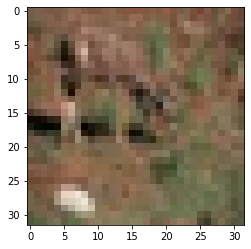

(52500, 32, 32, 3)
4


In [2]:
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn

# !wget -nc http://ml_course.gordinmitya.ru/modified_public.zip
# !unzip -o modified_public.zip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split

X = np.load('/ml_project/modified_public/xs.npy')
y = np.load('/ml_project/modified_public/ys.npy')

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
x_train = X
y_train = y

for i in range(1):
    a = randint(0, len(x_train))
    plt.imshow(x_train[a])
    plt.show()

print(x_train.shape)
print(y_train[a])


## Ниже не трогать

In [ ]:
from tensorflow.python import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Lambda
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.experimental.preprocessing import Resizing

from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.applications import EfficientNetB0
from keras import regularizers

# print(keras.__version__)

def make_model():
    inputs = keras.Input(shape = (32,32,3))
    resize = Resizing(224, 224, interpolation="bilinear",)(inputs)

    prep_inputs = Lambda(keras.applications.efficientnet.preprocess_input)(resize)

    model_e = EfficientNetB0(
        include_top=False, 
        weights='imagenet',
        input_tensor = prep_inputs,
        pooling=None,
        classes=9, 
        classifier_activation='softmax'
    )

    model_e.trainable = False
    x = model_e.output
    
    weight_decay = 0.0005
    x = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    x = Dense(9,activation='softmax')(x)

    model= keras.Model(model_e.input,x)
    return model


strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = make_model()
    model.compile(optimizer=Nadam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=True)

lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=6)

# model.fit(x=x_train, y=y_train,
#           validation_split=0.1,
#           epochs=3,
#           verbose=2,
#           batch_size=128,
#           callbacks=[early_stopping, lr_schedule])

# With data argumentation
generator = ImageDataGenerator(width_shift_range=0.125,
                               height_shift_range=0.125,
                               horizontal_flip=True,
                               validation_split=0.15,
                               fill_mode='constant',
                               cval=0.,
                               shear_range=0.1)

model.fit(generator.flow(x_train, y_train, batch_size=128),
          validation_data=generator.flow(x_train, y_train, batch_size=128, subset='validation'),
          steps_per_epoch=len(x_train)/ 128,
          epochs=3,
          verbose=2,
          callbacks=[early_stopping, lr_schedule])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/3
411/410 - 40s - loss: 1.2794 - accuracy: 0.6804 - val_loss: 0.7890 - val_accuracy: 0.8617
Epoch 2/3


In [13]:
#print(model.evaluate(x_test, y_test))
model.save('model.h5')

In [5]:
xt_train = np.load('/ml_project/modified_public/xt_modified.npy')

print(len(xt_train))
print(len(x_train))

# get probability
yt_train_prob = model.predict(xt_train)

# Get labels with max confident
labels = np.argmax(yt_train_prob, axis=1)
prob_max = np.max(yt_train_prob, axis=1)

yt_train = labels[...,np.newaxis]

10001
52500


(10001, 10) (10001,)


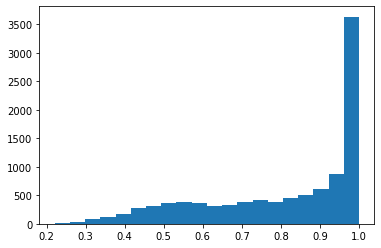

In [6]:
# Get hystogram of probabilities
plt.hist(prob_max, bins=20)
print(yt_train_prob.shape, prob_max.shape)

In [13]:
# Level of confidence
CONFIDENCE=0.95

# Filter
mask = prob_max > CONFIDENCE
xt_confident = xt_train[mask]
yt_confident = yt_train[mask]

print(xt_confident.shape)

(3926, 32, 32, 3)


In [14]:
# Return data with max confident
def get_pseudo_labels(model):
    yt_train_prob = model.predict(xt_train)
    labels = np.argmax(yt_train_prob, axis=1)
    prob_max = np.max(yt_train_prob, axis=1)
    yt_train = labels[...,np.newaxis]
    mask = prob_max > CONFIDENCE
    xt_confident = xt_train[mask]
    yt_confident = yt_train[mask]
    return xt_confident, yt_confident

In [15]:
def train_classifier(model, X, Y, epochs=15, compile=True):
    if compile:
        model.compile(optimizer=Nadam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   patience=10,
                                   restore_best_weights=True)

    lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=6)

#     model.fit(x=x_train, y=y_train,
#               validation_split=0.1,
#               epochs=30,
#               verbose=2,
#               batch_size=128,
#               callbacks=[early_stopping, lr_schedule])
    
    # With data augmentation!
    generator = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               validation_split=0.15)

    model.fit(generator.flow(x_train, y_train, batch_size=128),
              validation_data=generator.flow(x_train, y_train, batch_size=128, subset='validation'),
              steps_per_epoch=len(x_train)/ 128,
              epochs=epochs,
              verbose=2,
              callbacks=[early_stopping, lr_schedule])

In [16]:
# Iteration
for iter in range(15):
    print(f"\n{'*'*48}\niteration #{iter+1}\n{'*'*48}")
    
    #pseudo-labels
    x_ps, y_ps = get_pseudo_labels(model)
    print(f"{y_ps.shape[0]} samples from target set with confidence>{CONFIDENCE*100}%\n")
    
    # !!! AUGMENTATION !!!
    
    train_classifier(model, x_ps, y_ps, epochs=10)

    #print("\nGet the accuracy on the target set.")
    #model.evaluate(xt_test, yt_test)


************************************************
iteration #1
************************************************
4540 samples from target set with confidence>95.0%

Epoch 1/10
411/410 - 43s - loss: 0.2791 - accuracy: 0.9032 - val_loss: 0.1219 - val_accuracy: 0.9622
Epoch 2/10
411/410 - 42s - loss: 0.2720 - accuracy: 0.9060 - val_loss: 0.1186 - val_accuracy: 0.9630
Epoch 3/10
411/410 - 40s - loss: 0.2696 - accuracy: 0.9070 - val_loss: 0.1093 - val_accuracy: 0.9661
Epoch 4/10
411/410 - 43s - loss: 0.2699 - accuracy: 0.9047 - val_loss: 0.1114 - val_accuracy: 0.9647
Epoch 5/10
411/410 - 43s - loss: 0.2646 - accuracy: 0.9070 - val_loss: 0.1041 - val_accuracy: 0.9652
Epoch 6/10
411/410 - 42s - loss: 0.2577 - accuracy: 0.9098 - val_loss: 0.1058 - val_accuracy: 0.9661
Epoch 7/10
411/410 - 40s - loss: 0.2532 - accuracy: 0.9099 - val_loss: 0.1034 - val_accuracy: 0.9661
Epoch 8/10
411/410 - 41s - loss: 0.2500 - accuracy: 0.9125 - val_loss: 0.1057 - val_accuracy: 0.9655
Epoch 9/10
411/410 - 41s - l

In [18]:
#print(model.evaluate(x_test, y_test))
model.save('model.h5')